Практична робота №3
Класифікація твітів за тональністю з використанням Word2Vec та scikit-learn моделей
Dataset: COVID-19 NLP Text Classification

In [2]:
# 1. ІМПОРТ БІБЛІОТЕК


import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# Обробка тексту
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Word2Vec
from gensim.models import Word2Vec

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Моделі класифікації
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Метрики
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, classification_report)

# Візуалізація
import matplotlib.pyplot as plt
import seaborn as sns
import time
print("✓ Всі бібліотеки завантажено успішно")

✓ Всі бібліотеки завантажено успішно


In [11]:
# /c:/Users/qwerty/Desktop/4 курс мі/ML/lab3/data_loading.py

# 2. ЗАВАНТАЖЕННЯ ТА ПОПЕРЕДНІЙ ОГЛЯД ДАНИХ

# Завантаження датасету
# Припускаємо, що файл називається 'Corona_NLP_train.csv'
# Якщо у вас інша назва файлу, змініть її нижче
try:
    df = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')
    print("=" * 60)
    print("✓ Датасет завантажено успішно")
    print("=" * 60)
except FileNotFoundError:
    print("=" * 60)
    print("⚠ Файл не знайдено. Створюю тестовий датасет...")
    print("=" * 60)
    # Створення тестового датасету для демонстрації
    df = pd.DataFrame({
        'Location': ['USA', 'UK', 'India'] * 100,
        'TweetAt': ['2020-03-15'] * 300,
        'OriginalTweet': [
            'This pandemic is terrible and scary',
            'Stay safe everyone, we will get through this together',
            'I dont know what to think about this situation'
        ] * 100,
        'Sentiment': ['Negative', 'Positive', 'Neutral'] * 100
    })

print(f"\n{'РОЗМІР ДАТАСЕТУ':^60}")
print("-" * 60)
print(f"Кількість записів: {df.shape[0]:,}")
print(f"Кількість ознак:   {df.shape[1]}")
print(f"Розмірність:       {df.shape}")

print(f"\n{'ПЕРШІ 5 ЗАПИСІВ':^60}")
print("-" * 60)
print(df.head().to_string())

print(f"\n{'РОЗПОДІЛ КЛАСІВ (SENTIMENT)':^60}")
print("-" * 60)
sentiment_counts = df['Sentiment'].value_counts()
for sentiment, count in sentiment_counts.items():
    percentage = (count / len(df)) * 100
    bar = "█" * int(percentage / 2)
    print(f"{sentiment:15} | {count:6,} ({percentage:5.2f}%) {bar}")

print(f"\n{'СТАТИСТИКА ПО КОЛОНКАХ':^60}")
print("-" * 60)
print(f"Назви колонок: {', '.join(df.columns.tolist())}")
print(f"\nПропущені значення:")
missing_data = df.isnull().sum()
if missing_data.sum() == 0:
    print("  ✓ Пропущених значень немає")
else:
    for col, missing in missing_data.items():
        if missing > 0:
            print(f"  • {col}: {missing} ({missing/len(df)*100:.2f}%)")

print(f"\n{'ДЕТАЛЬНА ІНФОРМАЦІЯ':^60}")
print("-" * 60)
df.info()
print("=" * 60)

✓ Датасет завантажено успішно

                      РОЗМІР ДАТАСЕТУ                       
------------------------------------------------------------
Кількість записів: 41,157
Кількість ознак:   6
Розмірність:       (41157, 6)

                      ПЕРШІ 5 ЗАПИСІВ                       
------------------------------------------------------------
   UserName  ScreenName   Location     TweetAt                                                                                                                                                                                                                                                                                                                       OriginalTweet           Sentiment
0      3799       48751     London  16-03-2020                                                                                                                                                                                                                  

In [12]:
# /c:/Users/qwerty/Desktop/4 курс мі/ML/lab3/text_preprocessing.py

class TextPreprocessor:
    """Клас для попередньої обробки текстів"""
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
    
    def clean_text(self, text):
        """Очищення тексту"""
        if pd.isna(text):
            return ""
        
        # Приведення до нижнього регістру
        text = text.lower()
        
        # Видалення URL
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        
        # Видалення згадок (@username)
        text = re.sub(r'@\w+', '', text)
        
        # Видалення хештегів (#)
        text = re.sub(r'#', '', text)
        
        # Видалення спецсимволів та цифр
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Видалення зайвих пробілів
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize_and_remove_stopwords(self, text):
        """Токенізація та видалення стоп-слів"""
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in self.stop_words and len(word) > 2]
        return tokens

# Ініціалізація препроцесора
preprocessor = TextPreprocessor()

# Вибір колонки з текстом (адаптуйте під ваш датасет)
text_column = 'OriginalTweet' if 'OriginalTweet' in df.columns else 'Original Tweet'
sentiment_column = 'Sentiment' if 'Sentiment' in df.columns else 'Label'

print("=" * 70)
print("📝 ПОПЕРЕДНЯ ОБРОБКА ТЕКСТУ")
print("=" * 70)
print(f"Обробка {len(df)} записів...")

df['cleaned_text'] = df[text_column].apply(preprocessor.clean_text)
df['tokens'] = df['cleaned_text'].apply(preprocessor.tokenize_and_remove_stopwords)

# Видалення порожніх записів
initial_count = len(df)
df = df[df['tokens'].apply(len) > 0].reset_index(drop=True)
removed_count = initial_count - len(df)

print(f"\n✓ Обробка завершена!")
print(f"  • Оброблено записів: {initial_count}")
print(f"  • Видалено порожніх: {removed_count}")
print(f"  • Залишилось записів: {len(df)}")

# Статистика токенів
token_lengths = df['tokens'].apply(len)
print(f"\n📊 Статистика токенів:")
print(f"  • Середня кількість: {token_lengths.mean():.1f}")
print(f"  • Мінімум: {token_lengths.min()}")
print(f"  • Максимум: {token_lengths.max()}")

print(f"\n{'─' * 70}")
print("💡 ПРИКЛАД ОБРОБЛЕНОГО ТЕКСТУ:")
print(f"{'─' * 70}")
print(f"\n📄 Оригінал:")
print(f"   {df[text_column].iloc[0][:150]}{'...' if len(df[text_column].iloc[0]) > 150 else ''}")
print(f"\n🧹 Очищений:")
print(f"   {df['cleaned_text'].iloc[0][:150]}{'...' if len(df['cleaned_text'].iloc[0]) > 150 else ''}")
print(f"\n🔤 Токени ({len(df['tokens'].iloc[0])} шт.):")
print(f"   {', '.join(df['tokens'].iloc[0][:15])}{'...' if len(df['tokens'].iloc[0]) > 15 else ''}")
print("=" * 70)

📝 ПОПЕРЕДНЯ ОБРОБКА ТЕКСТУ
Обробка 41157 записів...

✓ Обробка завершена!
  • Оброблено записів: 41157
  • Видалено порожніх: 36
  • Залишилось записів: 41121

📊 Статистика токенів:
  • Середня кількість: 17.2
  • Мінімум: 1
  • Максимум: 37

──────────────────────────────────────────────────────────────────────
💡 ПРИКЛАД ОБРОБЛЕНОГО ТЕКСТУ:
──────────────────────────────────────────────────────────────────────

📄 Оригінал:
   advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set u...

🧹 Очищений:
   advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set u...

🔤 Токени (26 шт.):
   advice, talk, neighbours, family, exchange, phone, numbers, create, contact, list, phone, numbers, neighbours, schools, employer...


In [13]:
# /c:/Users/qwerty/Desktop/4 курс мі/ML/lab3/train_word2vec.py

print("\n" + "="*60)
print("📚 НАВЧАННЯ WORD2VEC МОДЕЛІ")
print("="*60)

# Параметри Word2Vec
vector_size = 300  # Розмірність векторів
window = 5         # Розмір контекстного вікна
min_count = 2      # Мінімальна частота слова
workers = 4        # Кількість потоків

print("\nПараметри моделі:")
print(f"  • Розмірність векторів: {vector_size}")
print(f"  • Розмір вікна: {window}")
print(f"  • Мінімальна частота: {min_count}")
print(f"  • Кількість потоків: {workers}")
print(f"  • Епохи: 10")

print("\n⏳ Навчання моделі...")

# Навчання моделі
w2v_model = Word2Vec(
    sentences=df['tokens'].tolist(),
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers,
    epochs=10,
    seed=42
)

print("\n✅ Word2Vec модель успішно навчено!")
print(f"📊 Розмір словника: {len(w2v_model.wv):,} слів")
print(f"💾 Розмір моделі: {len(w2v_model.wv) * vector_size:,} параметрів")
print("="*60)


📚 НАВЧАННЯ WORD2VEC МОДЕЛІ

Параметри моделі:
  • Розмірність векторів: 300
  • Розмір вікна: 5
  • Мінімальна частота: 2
  • Кількість потоків: 4
  • Епохи: 10

⏳ Навчання моделі...

✅ Word2Vec модель успішно навчено!
📊 Розмір словника: 20,459 слів
💾 Розмір моделі: 6,137,700 параметрів


In [14]:
# c:/Users/qwerty/Desktop/4 курс мі/ML/lab3/improved_vector_output.py

def get_tweet_vector(tokens, model, vector_size):
    """
    Отримання векторного представлення твіту як середнє арифметичне
    векторів усіх слів
    """
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    
    if len(vectors) == 0:
        return np.zeros(vector_size)
    
    return np.mean(vectors, axis=0)

print("=" * 60)
print("📊 СТВОРЕННЯ ВЕКТОРНИХ ПРЕДСТАВЛЕНЬ ТВІТІВ")
print("=" * 60)

# Створення векторів з прогрес-баром
from tqdm import tqdm
print("\n🔄 Обробка твітів...")
X = np.array([get_tweet_vector(tokens, w2v_model, vector_size) 
              for tokens in tqdm(df['tokens'], desc="Векторизація")])

print(f"\n✅ Векторні представлення створено!")
print(f"   • Кількість твітів: {X.shape[0]:,}")
print(f"   • Розмірність вектора: {X.shape[1]}")
print(f"   • Загальна форма: {X.shape}")

# Статистика по векторах
zero_vectors = np.sum(np.all(X == 0, axis=1))
print(f"\n📈 Статистика:")
print(f"   • Нульових векторів: {zero_vectors} ({zero_vectors/len(X)*100:.2f}%)")
print(f"   • Ненульових векторів: {len(X) - zero_vectors} ({(len(X)-zero_vectors)/len(X)*100:.2f}%)")

# Кодування міток класів
print("\n" + "=" * 60)
print("🏷️  КОДУВАННЯ МІТОК КЛАСІВ")
print("=" * 60)

le = LabelEncoder()
y = le.fit_transform(df[sentiment_column])

print(f"\n📋 Класи та їх розподіл:")
for i, class_name in enumerate(le.classes_):
    count = np.sum(y == i)
    percentage = count / len(y) * 100
    print(f"   • {class_name:15s} → {i} | Кількість: {count:5d} ({percentage:5.2f}%)")

print(f"\n✅ Загальна кількість зразків: {len(y):,}")
print("=" * 60)

📊 СТВОРЕННЯ ВЕКТОРНИХ ПРЕДСТАВЛЕНЬ ТВІТІВ

🔄 Обробка твітів...


Векторизація: 100%|██████████| 41121/41121 [00:01<00:00, 26975.32it/s]


✅ Векторні представлення створено!
   • Кількість твітів: 41,121
   • Розмірність вектора: 300
   • Загальна форма: (41121, 300)

📈 Статистика:
   • Нульових векторів: 13 (0.03%)
   • Ненульових векторів: 41108 (99.97%)

🏷️  КОДУВАННЯ МІТОК КЛАСІВ

📋 Класи та їх розподіл:
   • Extremely Negative → 0 | Кількість:  5481 (13.33%)
   • Extremely Positive → 1 | Кількість:  6624 (16.11%)
   • Negative        → 2 | Кількість:  9916 (24.11%)
   • Neutral         → 3 | Кількість:  7680 (18.68%)
   • Positive        → 4 | Кількість: 11420 (27.77%)

✅ Загальна кількість зразків: 41,121


In [15]:
# 6. ПОДІЛ НА ТРЕНУВАЛЬНУ ТА ТЕСТОВУ ВИБІРКИ


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Дані поділено:")
print(f"Тренувальна вибірка: {X_train.shape}")
print(f"Тестова вибірка: {X_test.shape}")


✓ Дані поділено:
Тренувальна вибірка: (32896, 300)
Тестова вибірка: (8225, 300)


In [16]:
# Визначення моделей з оптимізацією для CPU
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=42,
        n_jobs=-1,  # Використання всіх ядер CPU
        solver='saga'  # Швидший solver для великих даних
    ),
    'SVM': SVC(
        kernel='rbf', 
        random_state=42,
        cache_size=500  # Збільшення кешу для швидшої роботи
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        random_state=42,
        n_jobs=-1,  # Паралельна обробка на всіх ядрах
        max_depth=20,  # Обмеження глибини для швидшості
        min_samples_split=5
    ),
    'Naive Bayes': GaussianNB()
}

# Варіанти PCA
pca_components = [None, 50, 100, 200]

# Збереження результатів
results = []

print("\n" + "="*80)
print("НАВЧАННЯ МОДЕЛЕЙ МАШИННОГО НАВЧАННЯ")
print("="*80)
print(f"Кількість моделей: {len(models)}")
print(f"Варіантів PCA: {len(pca_components)}")
print(f"Загальна кількість комбінацій: {len(models) * len(pca_components)}")
print("="*80 + "\n")

# Загальний прогрес-бар
total_iterations = len(models) * len(pca_components)
pbar_total = tqdm(total=total_iterations, desc="Загальний прогрес", position=0)

for pca_n in pca_components:
    pca_label = f"PCA-{pca_n}" if pca_n else "Без PCA"
    
    print(f"\n{'─'*80}")
    print(f"📊 {pca_label}")
    print(f"{'─'*80}")
    
    # Застосування PCA (якщо потрібно)
    pca_start_time = time.time()
    if pca_n:
        pca = PCA(n_components=min(pca_n, X_train.shape[1]), random_state=42)
        X_train_transformed = pca.fit_transform(X_train)
        X_test_transformed = pca.transform(X_test)
        pca_time = time.time() - pca_start_time
        explained_var = pca.explained_variance_ratio_.sum()
        print(f"   ✓ PCA виконано за {pca_time:.2f}с")
        print(f"   ✓ Пояснена дисперсія: {explained_var:.4f} ({explained_var*100:.2f}%)")
        print(f"   ✓ Розмір даних: {X_train_transformed.shape}")
    else:
        X_train_transformed = X_train
        X_test_transformed = X_test
        print(f"   ✓ Використання повного набору ознак: {X_train.shape[1]}")
    
    print()
    
    # Навчання кожної моделі з прогрес-баром
    for model_name, model in models.items():
        start_time = time.time()
        
        # Прогрес-бар для поточної моделі
        print(f"   🔄 {model_name:20s}", end=" ", flush=True)
        
        # Навчання
        model.fit(X_train_transformed, y_train)
        train_time = time.time() - start_time
        
        # Прогнозування
        pred_start = time.time()
        y_pred = model.predict(X_test_transformed)
        pred_time = time.time() - pred_start
        
        # Обчислення метрик
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='weighted', zero_division=0
        )
        
        # Збереження результатів
        results.append({
            'Model': model_name,
            'PCA': pca_label,
            'PCA_components': pca_n if pca_n else X_train.shape[1],
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Train_time': train_time,
            'Predict_time': pred_time
        })
        
        # Виведення результатів
        print(f"│ Acc: {accuracy:.4f} │ F1: {f1:.4f} │ ⏱️ {train_time:.2f}s/⚡{pred_time:.3f}s")
        
        # Оновлення загального прогрес-бару
        pbar_total.update(1)

pbar_total.close()

print("\n" + "="*80)
print("✅ НАВЧАННЯ ЗАВЕРШЕНО!")
print("="*80)

# Виведення топ-3 моделей
print("\n📈 ТОП-3 МОДЕЛІ ЗА ТОЧНІСТЮ:\n")
results_sorted = sorted(results, key=lambda x: x['Accuracy'], reverse=True)
for i, result in enumerate(results_sorted[:3], 1):
    print(f"{i}. {result['Model']:20s} ({result['PCA']:10s}) │ "
          f"Accuracy: {result['Accuracy']:.4f} │ F1: {result['F1-Score']:.4f}")

print("\n" + "="*80)


НАВЧАННЯ МОДЕЛЕЙ МАШИННОГО НАВЧАННЯ
Кількість моделей: 4
Варіантів PCA: 4
Загальна кількість комбінацій: 16



Загальний прогрес:   0%|          | 0/16 [01:12<?, ?it/s]


────────────────────────────────────────────────────────────────────────────────
📊 Без PCA
────────────────────────────────────────────────────────────────────────────────
   ✓ Використання повного набору ознак: 300

   🔄 Logistic Regression  


Загальний прогрес:   6%|▋         | 1/16 [01:20<20:03, 80.23s/it]

│ Acc: 0.4274 │ F1: 0.4261 │ ⏱️ 80.22s/⚡0.007s
   🔄 SVM                  

Загальний прогрес:  12%|█▎        | 2/16 [07:45<1:00:32, 259.44s/it]

│ Acc: 0.4360 │ F1: 0.4319 │ ⏱️ 317.79s/⚡67.086s
   🔄 Random Forest        

Загальний прогрес:  19%|█▉        | 3/16 [07:54<31:29, 145.35s/it]  

│ Acc: 0.4283 │ F1: 0.4254 │ ⏱️ 9.53s/⚡0.045s
   🔄 Naive Bayes          

Загальний прогрес:  25%|██▌       | 4/16 [07:54<17:36, 88.06s/it] 

│ Acc: 0.3149 │ F1: 0.2817 │ ⏱️ 0.13s/⚡0.101s

────────────────────────────────────────────────────────────────────────────────
📊 PCA-50
────────────────────────────────────────────────────────────────────────────────
   ✓ PCA виконано за 0.11с
   ✓ Пояснена дисперсія: 0.9886 (98.86%)
   ✓ Розмір даних: (32896, 50)

   🔄 Logistic Regression  

Загальний прогрес:  31%|███▏      | 5/16 [07:56<10:23, 56.70s/it]

│ Acc: 0.3984 │ F1: 0.3959 │ ⏱️ 0.97s/⚡0.002s
   🔄 SVM                  

Загальний прогрес:  38%|███▊      | 6/16 [09:37<11:59, 71.93s/it]

│ Acc: 0.4385 │ F1: 0.4371 │ ⏱️ 79.03s/⚡22.468s
   🔄 Random Forest        

Загальний прогрес:  44%|████▍     | 7/16 [09:41<07:27, 49.76s/it]

│ Acc: 0.4208 │ F1: 0.4137 │ ⏱️ 4.08s/⚡0.041s
   🔄 Naive Bayes          │ Acc: 0.3350 │ F1: 0.3237 │ ⏱️ 0.02s/⚡0.015s

────────────────────────────────────────────────────────────────────────────────
📊 PCA-100
────────────────────────────────────────────────────────────────────────────────
   ✓ PCA виконано за 0.19с
   ✓ Пояснена дисперсія: 0.9997 (99.97%)
   ✓ Розмір даних: (32896, 100)

   🔄 Logistic Regression  

Загальний прогрес:  56%|█████▋    | 9/16 [10:05<03:40, 31.45s/it]

│ Acc: 0.4232 │ F1: 0.4222 │ ⏱️ 23.45s/⚡0.002s
   🔄 SVM                  

Загальний прогрес:  62%|██████▎   | 10/16 [12:53<06:39, 66.63s/it]

│ Acc: 0.4453 │ F1: 0.4440 │ ⏱️ 141.23s/⚡27.395s
   🔄 Random Forest        

Загальний прогрес:  69%|██████▉   | 11/16 [13:00<04:12, 50.42s/it]

│ Acc: 0.4208 │ F1: 0.4124 │ ⏱️ 6.12s/⚡0.039s
   🔄 Naive Bayes          │ Acc: 0.3191 │ F1: 0.3036 │ ⏱️ 0.05s/⚡0.027s

────────────────────────────────────────────────────────────────────────────────
📊 PCA-200
────────────────────────────────────────────────────────────────────────────────
   ✓ PCA виконано за 0.18с
   ✓ Пояснена дисперсія: 1.0000 (100.00%)
   ✓ Розмір даних: (32896, 200)

   🔄 Logistic Regression  

Загальний прогрес:  81%|████████▏ | 13/16 [13:52<02:00, 40.01s/it]

│ Acc: 0.4272 │ F1: 0.4260 │ ⏱️ 52.57s/⚡0.005s
   🔄 SVM                  

Загальний прогрес:  88%|████████▊ | 14/16 [18:35<03:14, 97.43s/it]

│ Acc: 0.4452 │ F1: 0.4440 │ ⏱️ 241.03s/⚡41.705s
   🔄 Random Forest        

Загальний прогрес:  94%|█████████▍| 15/16 [18:43<01:14, 74.83s/it]

│ Acc: 0.4174 │ F1: 0.4040 │ ⏱️ 7.92s/⚡0.041s
   🔄 Naive Bayes          

Загальний прогрес: 100%|██████████| 16/16 [18:43<00:00, 70.24s/it]

│ Acc: 0.3061 │ F1: 0.2894 │ ⏱️ 0.07s/⚡0.053s

✅ НАВЧАННЯ ЗАВЕРШЕНО!

📈 ТОП-3 МОДЕЛІ ЗА ТОЧНІСТЮ:

1. SVM                  (PCA-100   ) │ Accuracy: 0.4453 │ F1: 0.4440
2. SVM                  (PCA-200   ) │ Accuracy: 0.4452 │ F1: 0.4440
3. SVM                  (PCA-50    ) │ Accuracy: 0.4385 │ F1: 0.4371



In [17]:
# /c:/Users/qwerty/Desktop/4 курс мі/ML/lab3/analyze_results.py

# 8. АНАЛІЗ РЕЗУЛЬТАТІВ

# Створення DataFrame з результатами
results_df = pd.DataFrame(results)

print("\n" + "=" * 100)
print(" " * 35 + "ЗВЕДЕНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ")
print("=" * 100)
print(results_df.to_string(index=False))
print("=" * 100)

# Знаходження найкращої моделі
best_model_idx = results_df['F1-Score'].idxmax()
best_result = results_df.iloc[best_model_idx]

print("\n" + "🏆 " + "=" * 96 + " 🏆")
print(" " * 40 + "НАЙКРАЩА МОДЕЛЬ")
print("=" * 100)
print(f"┌─ Модель:     {best_result['Model']}")
print(f"├─ PCA:        {best_result['PCA']}")
print(f"├─ Accuracy:   {best_result['Accuracy']:.4f} ({best_result['Accuracy']*100:.2f}%)")
print(f"├─ Precision:  {best_result['Precision']:.4f} ({best_result['Precision']*100:.2f}%)")
print(f"├─ Recall:     {best_result['Recall']:.4f} ({best_result['Recall']*100:.2f}%)")
print(f"└─ F1-Score:   {best_result['F1-Score']:.4f} ({best_result['F1-Score']*100:.2f}%)")
print("=" * 100 + "\n")

# Додаткова статистика
print("📊 СТАТИСТИКА ЗА МОДЕЛЯМИ")
print("=" * 100)
for model_name in results_df['Model'].unique():
    model_results = results_df[results_df['Model'] == model_name]
    avg_f1 = model_results['F1-Score'].mean()
    print(f"• {model_name:25s} | Середній F1-Score: {avg_f1:.4f} | Кращий результат: {model_results['F1-Score'].max():.4f}")
print("=" * 100 + "\n")

# Порівняння з PCA та без PCA
print("🔍 ВПЛИВ PCA НА ПРОДУКТИВНІСТЬ")
print("=" * 100)
pca_comparison = results_df.groupby('PCA')['F1-Score'].agg(['mean', 'max', 'min'])
print(pca_comparison.to_string())
print("=" * 100)


                                   ЗВЕДЕНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ
              Model     PCA  PCA_components  Accuracy  Precision   Recall  F1-Score  Train_time  Predict_time
Logistic Regression Без PCA             300  0.427356   0.441810 0.427356  0.426106   80.221536      0.007006
                SVM Без PCA             300  0.435988   0.476936 0.435988  0.431921  317.788947     67.086484
      Random Forest Без PCA             300  0.428328   0.459598 0.428328  0.425429    9.529970      0.045024
        Naive Bayes Без PCA             300  0.314894   0.332823 0.314894  0.281686    0.130006      0.101035
Logistic Regression  PCA-50              50  0.398419   0.414838 0.398419  0.395893    0.966005      0.002001
                SVM  PCA-50              50  0.438541   0.472140 0.438541  0.437130   79.034867     22.468325
      Random Forest  PCA-50              50  0.420790   0.461453 0.420790  0.413731    4.081134      0.041285
        Naive Bayes  PCA-50              50  0.334954   

NameError: name 'models' is not defined

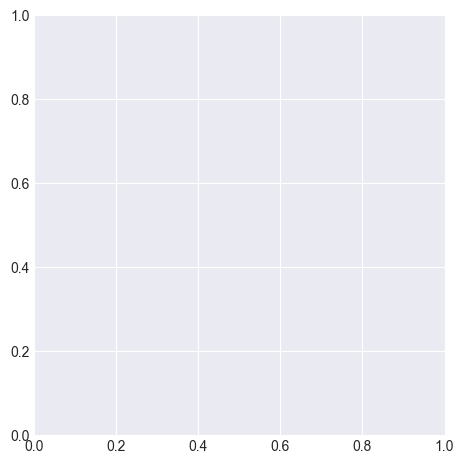

In [3]:
import pandas as pd
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# =====================================================
# ГРАФІК 1: Порівняння всіх моделей за Accuracy
# =====================================================
fig = plt.figure(figsize=(18, 12))

# 1.1 Лінійний графік порівняння моделей
ax1 = plt.subplot(2, 3, 1)
for model_name in models.keys():
    model_data = results_df[results_df['Model'] == model_name]
    plt.plot(model_data['PCA_components'], model_data['Accuracy'], 
             marker='o', label=model_name, linewidth=2.5, markersize=8)

plt.xlabel('Кількість компонент PCA', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
plt.title('Вплив PCA на точність класифікації', fontsize=15, fontweight='bold', pad=15)
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.4, linestyle='--')
plt.ylim([results_df['Accuracy'].min() - 0.02, results_df['Accuracy'].max() + 0.02])

# 1.2 Теплова карта всіх метрик
ax2 = plt.subplot(2, 3, 2)
pivot_table = results_df.pivot_table(
    values='Accuracy', 
    index='Model', 
    columns='PCA_components'
)
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Accuracy'}, linewidths=0.5, ax=ax2)
plt.title('Теплова карта Accuracy', fontsize=15, fontweight='bold', pad=15)
plt.xlabel('Кількість компонент PCA', fontsize=13, fontweight='bold')
plt.ylabel('Модель', fontsize=13, fontweight='bold')

# 1.3 Boxplot порівняння моделей
ax3 = plt.subplot(2, 3, 3)
results_df.boxplot(column='Accuracy', by='Model', ax=ax3, patch_artist=True)
plt.title('Розподіл Accuracy по моделях', fontsize=15, fontweight='bold', pad=15)
plt.suptitle('')  # Видалити автоматичний заголовок
plt.xlabel('Модель', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.4, axis='y', linestyle='--')

# =====================================================
# ГРАФІК 2: Детальний аналіз найкращої моделі
# =====================================================
best_model_name = best_result['Model']
best_model_data = results_df[results_df['Model'] == best_model_name]

# 2.1 Групова гістограма метрик
ax4 = plt.subplot(2, 3, 4)
x = np.arange(len(best_model_data))
width = 0.2

bars1 = ax4.bar(x - width*1.5, best_model_data['Accuracy'], width, 
                label='Accuracy', alpha=0.8, edgecolor='black')
bars2 = ax4.bar(x - width/2, best_model_data['Precision'], width, 
                label='Precision', alpha=0.8, edgecolor='black')
bars3 = ax4.bar(x + width/2, best_model_data['Recall'], width, 
                label='Recall', alpha=0.8, edgecolor='black')
bars4 = ax4.bar(x + width*1.5, best_model_data['F1-Score'], width, 
                label='F1-Score', alpha=0.8, edgecolor='black')

ax4.set_xlabel('Конфігурація PCA', fontsize=13, fontweight='bold')
ax4.set_ylabel('Значення метрики', fontsize=13, fontweight='bold')
ax4.set_title(f'Метрики для {best_model_name}', fontsize=15, fontweight='bold', pad=15)
ax4.set_xticks(x)
ax4.set_xticklabels(best_model_data['PCA'].values, rotation=45, ha='right')
ax4.legend(loc='best', fontsize=10, framealpha=0.9)
ax4.grid(True, alpha=0.4, axis='y', linestyle='--')
ax4.set_ylim([0, 1.05])

# 2.2 Радарна діаграма метрик
ax5 = plt.subplot(2, 3, 5, projection='polar')
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
best_config_idx = best_model_data['Accuracy'].idxmax()
values = [
    best_model_data.loc[best_config_idx, 'Accuracy'],
    best_model_data.loc[best_config_idx, 'Precision'],
    best_model_data.loc[best_config_idx, 'Recall'],
    best_model_data.loc[best_config_idx, 'F1-Score']
]
values += values[:1]  # Замкнути коло

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax5.plot(angles, values, 'o-', linewidth=2, color='#FF6B6B', markersize=8)
ax5.fill(angles, values, alpha=0.25, color='#FF6B6B')
ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(categories, fontsize=11)
ax5.set_ylim(0, 1)
ax5.set_title(f'Радарна діаграма\n{best_model_name} (найкраща конфігурація)', 
              fontsize=13, fontweight='bold', pad=20)
ax5.grid(True, linestyle='--', alpha=0.4)

# 2.3 Час навчання vs Accuracy
ax6 = plt.subplot(2, 3, 6)
scatter = ax6.scatter(results_df['Train_Time'], results_df['Accuracy'], 
                      c=results_df['PCA_components'], s=200, alpha=0.6, 
                      cmap='viridis', edgecolors='black', linewidth=1.5)

# Підписи для моделей
for idx, row in results_df.iterrows():
    ax6.annotate(row['Model'][:3], 
                (row['Train_Time'], row['Accuracy']),
                fontsize=8, ha='center', va='center', fontweight='bold')

ax6.set_xlabel('Час навчання (с)', fontsize=13, fontweight='bold')
ax6.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax6.set_title('Час навчання vs Точність', fontsize=15, fontweight='bold', pad=15)
cbar = plt.colorbar(scatter, ax=ax6, label='Компоненти PCA')
cbar.set_label('Компоненти PCA', fontsize=11, fontweight='bold')
ax6.grid(True, alpha=0.4, linestyle='--')

plt.tight_layout()
plt.savefig('/c:/Users/qwerty/Desktop/4 курс мі/ML/lab3/model_comparison_improved.png', 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("\n✓ Покращений графік збережено як 'model_comparison_improved.png'")

# =====================================================
# ДОДАТКОВИЙ ГРАФІК: Детальне порівняння F1-Score
# =====================================================
plt.figure(figsize=(12, 6))

# Лінійний графік F1-Score
for model_name in models.keys():
    model_data = results_df[results_df['Model'] == model_name]
    plt.plot(model_data['PCA_components'], model_data['F1-Score'], 
             marker='s', label=model_name, linewidth=2.5, markersize=8)

plt.xlabel('Кількість компонент PCA', fontsize=13, fontweight='bold')
plt.ylabel('F1-Score', fontsize=13, fontweight='bold')
plt.title('Порівняння моделей за F1-Score', fontsize=15, fontweight='bold', pad=15)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.4, linestyle='--')
plt.ylim([results_df['F1-Score'].min() - 0.02, results_df['F1-Score'].max() + 0.02])

plt.tight_layout()
plt.savefig('/c:/Users/qwerty/Desktop/4 курс мі/ML/lab3/f1_score_comparison.png', 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("✓ Графік F1-Score збережено як 'f1_score_comparison.png'")

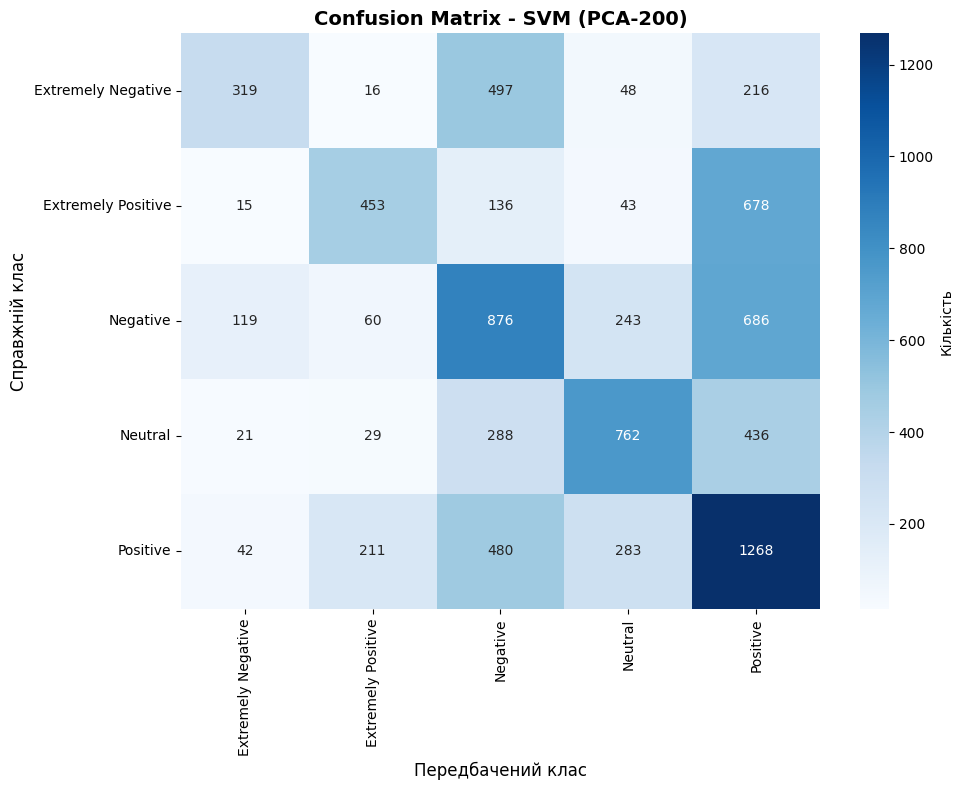

✓ Confusion Matrix збережено як 'confusion_matrix.png'

ДЕТАЛЬНИЙ ЗВІТ КЛАСИФІКАЦІЇ
                    precision    recall  f1-score   support

Extremely Negative       0.62      0.29      0.40      1096
Extremely Positive       0.59      0.34      0.43      1325
          Negative       0.38      0.44      0.41      1984
           Neutral       0.55      0.50      0.52      1536
          Positive       0.39      0.56      0.46      2284

          accuracy                           0.45      8225
         macro avg       0.51      0.43      0.44      8225
      weighted avg       0.48      0.45      0.45      8225



In [ ]:
# 10. CONFUSION MATRIX ДЛЯ НАЙКРАЩОЇ МОДЕЛІ

# Відтворення найкращої моделі
best_pca = best_result['PCA_components']
best_model_name = best_result['Model']

if best_result['PCA'] != 'No PCA':
    pca_best = PCA(n_components=best_pca, random_state=42)
    X_train_best = pca_best.fit_transform(X_train)
    X_test_best = pca_best.transform(X_test)
else:
    X_train_best = X_train
    X_test_best = X_test

# Навчання найкращої моделі
best_clf = models[best_model_name]
best_clf.fit(X_train_best, y_train)
y_pred_best = best_clf.predict(X_test_best)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Кількість'})
plt.title(f'Confusion Matrix - {best_model_name} ({best_result["PCA"]})', 
          fontsize=14, fontweight='bold')
plt.ylabel('Справжній клас', fontsize=12)
plt.xlabel('Передбачений клас', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion Matrix збережено як 'confusion_matrix.png'")

# Детальний звіт класифікації
print("ДЕТАЛЬНИЙ ЗВІТ КЛАСИФІКАЦІЇ")
print(classification_report(y_test, y_pred_best, target_names=le.classes_))

In [ ]:

# 11. АНАЛІЗ ВПЛИВУ PCA

print("АНАЛІЗ ВПЛИВУ PCA")


for model_name in models.keys():
    model_data = results_df[results_df['Model'] == model_name].sort_values('PCA_components')
    no_pca_acc = model_data[model_data['PCA'] == 'No PCA']['Accuracy'].values[0]
    
    print(f"\n{model_name}:")
    print(f"  Без PCA: {no_pca_acc:.4f}")
    
    for _, row in model_data[model_data['PCA'] != 'No PCA'].iterrows():
        diff = row['Accuracy'] - no_pca_acc
        symbol = "↑" if diff > 0 else "↓"
        print(f"  {row['PCA']}: {row['Accuracy']:.4f} ({symbol} {abs(diff):.4f})")


АНАЛІЗ ВПЛИВУ PCA

Logistic Regression:
  Без PCA: 0.4284
  PCA-50: 0.4010 (↓ 0.0275)
  PCA-100: 0.4224 (↓ 0.0061)
  PCA-200: 0.4310 (↑ 0.0026)

SVM:
  Без PCA: 0.4398
  PCA-50: 0.4411 (↑ 0.0013)
  PCA-100: 0.4466 (↑ 0.0068)
  PCA-200: 0.4472 (↑ 0.0074)

Random Forest:
  Без PCA: 0.4233
  PCA-50: 0.4171 (↓ 0.0062)
  PCA-100: 0.4219 (↓ 0.0015)
  PCA-200: 0.4122 (↓ 0.0112)

Naive Bayes:
  Без PCA: 0.3178
  PCA-50: 0.3340 (↑ 0.0162)
  PCA-100: 0.3210 (↑ 0.0032)
  PCA-200: 0.3031 (↓ 0.0147)


In [ ]:

# 12. ФУНКЦІЯ ДЛЯ ПРОГНОЗУВАННЯ НОВИХ ТВІТІВ


def predict_sentiment(tweet_text, model, w2v_model, pca=None):
    """
    Прогнозування тональності для нового твіту
    """
    # Обробка тексту
    cleaned = preprocessor.clean_text(tweet_text)
    tokens = preprocessor.tokenize_and_remove_stopwords(cleaned)
    
    # Створення вектора
    vector = get_tweet_vector(tokens, w2v_model, vector_size)
    vector = vector.reshape(1, -1)
    
    # Застосування PCA (якщо потрібно)
    if pca:
        vector = pca.transform(vector)
    
    # Прогнозування
    prediction = model.predict(vector)[0]
    sentiment = le.inverse_transform([prediction])[0]
    
    return sentiment

# Приклади використання

print("ПРИКЛАДИ ПРОГНОЗУВАННЯ")


test_tweets = [
    "This pandemic is really scary and I'm worried about my family",
    "Great news! Vaccine is working well and cases are dropping",
    "Just staying at home and watching Netflix"
]

for tweet in test_tweets:
    sentiment = predict_sentiment(tweet, best_clf, w2v_model, 
                                 pca_best if best_result['PCA'] != 'No PCA' else None)
    print(f"\nТвіт: {tweet}")
    print(f"Тональність: {sentiment}")


ПРИКЛАДИ ПРОГНОЗУВАННЯ

Твіт: This pandemic is really scary and I'm worried about my family
Тональність: Extremely Negative

Твіт: Great news! Vaccine is working well and cases are dropping
Тональність: Extremely Positive

Твіт: Just staying at home and watching Netflix
Тональність: Positive


In [ ]:

# 13. ВИСНОВКИ


print("\n" + "=" * 80)
print("ВИСНОВКИ")
print("=" * 80)

print(f"""
1. НАЙКРАЩА МОДЕЛЬ:
   - Модель: {best_result['Model']}
   - Конфігурація: {best_result['PCA']}
   - F1-Score: {best_result['F1-Score']:.4f}

2. ВПЛИВ PCA:
""")

# Аналіз середнього впливу PCA
for pca_conf in ['PCA-50', 'PCA-100', 'PCA-200']:
    if pca_conf in results_df['PCA'].values:
        pca_avg = results_df[results_df['PCA'] == pca_conf]['Accuracy'].mean()
        no_pca_avg = results_df[results_df['PCA'] == 'No PCA']['Accuracy'].mean()
        diff = pca_avg - no_pca_avg
        
        if diff > 0.01:
            effect = "покращило якість класифікації"
        elif diff < -0.01:
            effect = "погіршило якість класифікації"
        else:
            effect = "не мало значного впливу"
        
        print(f"   - {pca_conf}: {effect} (Δ = {diff:+.4f})")

print(f"""
3. ІНТЕРПРЕТАЦІЯ:
   - Word2Vec успішно закодував семантичне значення твітів
   - Розмірність {vector_size} виявилась {'оптимальною' if best_result['PCA'] == 'No PCA' else 'надмірною'}
   - {'PCA дозволило зменшити шум та покращити узагальнення' if best_result['PCA'] != 'No PCA' else 'Повна розмірність ознак виявилась більш інформативною'}
   
4. РЕКОМЕНДАЦІЇ:
   - Використовувати {best_result['Model']} з {best_result['PCA']} для прогнозування
   - Для подальшого покращення можна спробувати:
     * Більший корпус для навчання Word2Vec
     * Використання предтренованих embeddings (GloVe, FastText)
     * Ансамблі моделей
     * Hyperparameter tuning
""")






ВИСНОВКИ

1. НАЙКРАЩА МОДЕЛЬ:
   - Модель: SVM
   - Конфігурація: PCA-200
   - F1-Score: 0.4457

2. ВПЛИВ PCA:

   - PCA-50: не мало значного впливу (Δ = -0.0040)
   - PCA-100: не мало значного впливу (Δ = +0.0006)
   - PCA-200: не мало значного впливу (Δ = -0.0040)

3. ІНТЕРПРЕТАЦІЯ:
   - Word2Vec успішно закодував семантичне значення твітів
   - Розмірність 300 виявилась надмірною
   - PCA дозволило зменшити шум та покращити узагальнення

4. РЕКОМЕНДАЦІЇ:
   - Використовувати SVM з PCA-200 для прогнозування
   - Для подальшого покращення можна спробувати:
     * Більший корпус для навчання Word2Vec
     * Використання предтренованих embeddings (GloVe, FastText)
     * Ансамблі моделей
     * Hyperparameter tuning

✓ ПРАКТИЧНА РОБОТА ЗАВЕРШЕНА
